# Quick WL galaxy cluster mass determination example

Packages:

In [1]:
import numpy as np

#plots
from matplotlib import pyplot as plt
from getdist import plots, MCSamples

#astrophysics
#import galsim
import xlensing
from astropy.cosmology import FlatLambdaCDM

#saving
from astropy.table import Table
import pickle

#MCMC
import emcee

#utilities
#import os
import time
import warnings
import tqdm

#let's use multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
from functools import partial

warnings.filterwarnings('ignore')

Lookup table loaded!


Random distribution of non-cluster galaxies (not accurate with LSS):

Shear background galaxies:

In [2]:
Ngals = 1e6
M200true = 2e14
C200true = 3.5
Zcluster = 0.3
RAcluster = 0.0 #radians 
DECluster = 0.0 #radians

E1gals, E2gals, RAgals, DECgals, Zgals = xlensing.testing.gen_gal(Ngals=Ngals,Zcluster=Zcluster)

In [3]:
epsilon = xlensing.testing.NFW_shear( (M200true,C200true, 0, 0, .3),(RAgals, DECgals, Zgals, E1gals, E2gals) )
e1gals = np.real(epsilon)
e2gals = np.imag(epsilon)

e1err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e1gals])
e2err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e2gals])
Wgals = (0.1**2 + e1err**2 +e2err**2)/(0.1**2 + e1err**2 +e2err**2) #w=1
Mgals = -np.random.exponential(0.03,size=int(Ngals))*0

In [4]:
galaxy_catalog = Table([RAgals,DECgals,Zgals,e1gals,e2gals, Wgals,Mgals],names=['RA','DEC','ZPHOT','E1','E2','WEIGHT','M'])
#galaxy_catalog.write('mock_galaxy_catalog.fits',overwrite=True)

In [5]:
#cluster_catalog = Table([[RAcluster],[DECluster],[Zcluster]],names=['RA','DEC','Z'])
#cluster_catalog.write('mock_cluster_catalog.fits',overwrite=True)

## Using xlensing

Despite having only one cluster, we will pretend there are many.

In [6]:
#sources = Table.read('mock_galaxy_catalog.fits')
clusters = Table([[0],[0],[0.3]],names=['RA','DEC', 'Z'])

unpack clusters and data

In [7]:
sr_RA = np.array(galaxy_catalog['RA'])
sr_DEC= np.array(galaxy_catalog['DEC'])
sr_z  = np.array(galaxy_catalog['ZPHOT'])
sr_E1 = np.array(galaxy_catalog['E1'])
sr_E2 = np.array(galaxy_catalog['E2'])
sr_W = np.array(galaxy_catalog['WEIGHT'])
sr_M = np.array(galaxy_catalog['M'])

clusters['INDEX'] = np.array(range(len(clusters)))



In [8]:
cl_RA=np.array(clusters['RA'])
cl_DEC= np.array(clusters['DEC'])
cl_z= np.array(clusters['Z'])
cl = np.array([cl_RA,cl_DEC,cl_z]).T

In this first step, the code calculates e_t and sigma_crit for all clusters and all available galaxies in our survey. Galaxies are selected as background  for a cluster within a radius from the centre.

In [9]:
# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(cpu_count()) 

#We get a partial function with a constant galaxy catalogue to iterate with clusters.
survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, sr_DEC, sr_z, sr_E1, sr_E2, sr_W,sr_M),radius=10.)

In [10]:
#Make a list of clusters to get lensing data
clz = zip(cl_RA,cl_DEC,cl_z)
clzlist = [x for x in clz]

This next step needs multiprocessing because for a real survey, ~1e3 clusters and more than 1e6 galaxies take a long time.

In [11]:
results = pool.map(survey_lensing, clzlist)

In [12]:
#save the resulting list
#pickle_out = open("mock_results.pickle","wb")
#pickle.dump(results, pickle_out)
#pickle_out.close()

Lets investigate the product of our first step:

In [13]:
results

[{'Critical Density': array([4200.74019343, 4050.60175057, 4178.92285727, ..., 4215.54945445,
         5894.85869896, 4629.24100748]),
  'Tangential Shear': array([ 0.02170886, -0.17388629,  0.01237941, ...,  0.08324448,
          0.0003129 , -0.03742216]),
  'Cross Shear': array([ 0.13368889,  0.00202119, -0.19152779, ...,  0.05200074,
          0.14651121, -0.05103468]),
  'Radial Distance': array([5.61574646, 0.15010656, 4.4625973 , ..., 1.35279903, 6.43797337,
         5.56358961]),
  'Polar Angle': array([4.02312969, 3.22895093, 5.7450525 , ..., 3.59860567, 1.80644152,
         5.34049424]),
  'Weights': array([1., 1., 1., ..., 1., 1., 1.]),
  'Mult. Bias': array([-0., -0., -0., ..., -0., -0., -0.]),
  'Count': 392333}]

The result is a dictionary, containing entries for:

- Critical density: the critical surface density at the background galaxy redshift, for each galaxy
- Tangential shear: the tangential (relative to the cluster centre) component of the shear
- Cross shear: the cross component of the shear
- Radial distance: the separation between the background galaxy and the cluster centre in physical units (Mpc, angular diameter distance in the plane of the cluster)
- Polar angle: the azimuthal angle of the galaxy position relative to the cluster RA great circle
- Weights: lensifit weights
- Mult. Bias: the estimated multiplicative bias for the galaxy shape measurement
- Count: the number of galaxies considered "background"
 
Except for count, which is a number, all other dictionary keys should contain arrays of "Count" values.

Now let's define a radial bin structure for modelling the mass distribution:

In [14]:
radii = np.logspace(-0.8,0.8,8)
N = len(radii)
bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                        np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])
bins_lims #in Mpc/h

array([[0.12181879, 0.2061986 ],
       [0.2061986 , 0.34902549],
       [0.34902549, 0.59078379],
       [0.59078379, 1.        ],
       [1.        , 1.69266662],
       [1.69266662, 2.86512027],
       [2.86512027, 4.84969343],
       [4.84969343, 8.20891416]])

Here a "stick" is a list containing a set of "stacks", a "stack" is table containing a set of clusters. Since we have only 1 cluster, we will make a stick of 1 stack containing just a single cluster.

In [15]:
stick = [clusters]

In [16]:
Nboot=200
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    for index in stake['INDEX']:
        Sigma_crit = np.array(results[index]['Critical Density'])
        e_t = np.array(results[index]['Tangential Shear'])
        e_x = np.array(results[index]['Cross Shear'])
        W = np.array(results[index]['Weights'])
        M = np.array(results[index]['Mult. Bias'])
        R = np.array(results[index]['Radial Distance'])
        clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    print(len(clusterbkgs))
    sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.")




1
Total galaxies available per bin:
[3279, 5570, 9412, 16047, 27015, 46321, 77528, 131899]

Single cluster:
Separating galaxies per radial bin...
Done in 57.152390003204346 seconds.


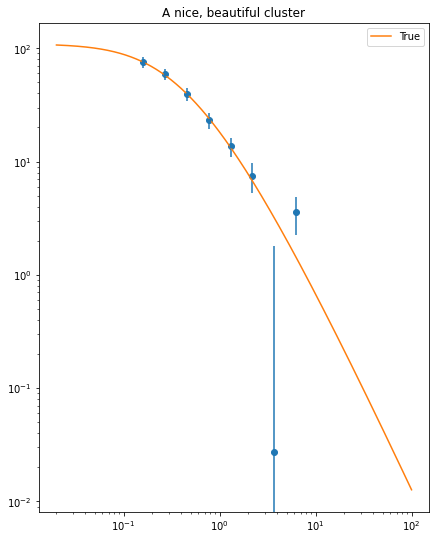

In [17]:
radii_model = np.logspace(np.log10(2e-2),2,500)
rs= xlensing.model.r_vir(Zcluster,M200true)/C200true
x = radii_model/rs
fact =  rs*xlensing.model.NFW_delta_c(C200true)*xlensing.cosmo.rhoM(Zcluster)/1e12
trueg = fact*np.array([xlensing.testing.gNFW(r) for r in x])
plt.figure(figsize=(7,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')

plt.plot(radii_model,trueg,label='True')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.title('A nice, beautiful cluster')
plt.savefig('mock.png')

## Model

Let's make a simplified version that takes only mass and concentration:

In [18]:
def NFWsimple(theta,Z,radii):
    logM200, C200  = theta
    M200 = np.power(10,logM200)
    result = xlensing.model.NFW_shear(M200, C200, Z, 1.0, 0.001, 1e10,radii)['NFW Signal'] #returns only the main shear signal - all other signals (incl cross signal) available see docstring
    return result

priors:

In [19]:
M200lo, M200hi = 13, 15
C200lo, C200hi = 0, 10

priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
#priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
prior = lambda theta : priorM200(theta) + priorC200(theta)# + priorPCC(theta)

In [20]:
ndim, nwalkers, steps = 2, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for stickresult in stick_results:

    mean_z = Zcluster

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        #PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

timestamp = time.time()
#don't mind the warnings for now

Running MCMC...
Done in 203.99498796463013 seconds.


Mvir: 1.94e+14 p 5.80e-02 m 6.24e-02
Conc: 3.51 p 0.60 m 0.50
Removed no burn in


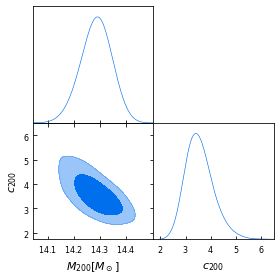

In [21]:
for samples in samplestick:
    mvir_tru,conc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(10**mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    #print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))

labs =  ["M_{200} [M_\\odot]", "c_{200}"]#,"p_{cc}"]

g = plots.getSubplotPlotter()
sample = [MCSamples(samples=samples, names = labs,labels=labs) for samples in samplestick]
g.triangle_plot(sample,filled=True)
g.fig.savefig(f'posterior_test_{timestamp}.pdf',bbox_inches='tight')

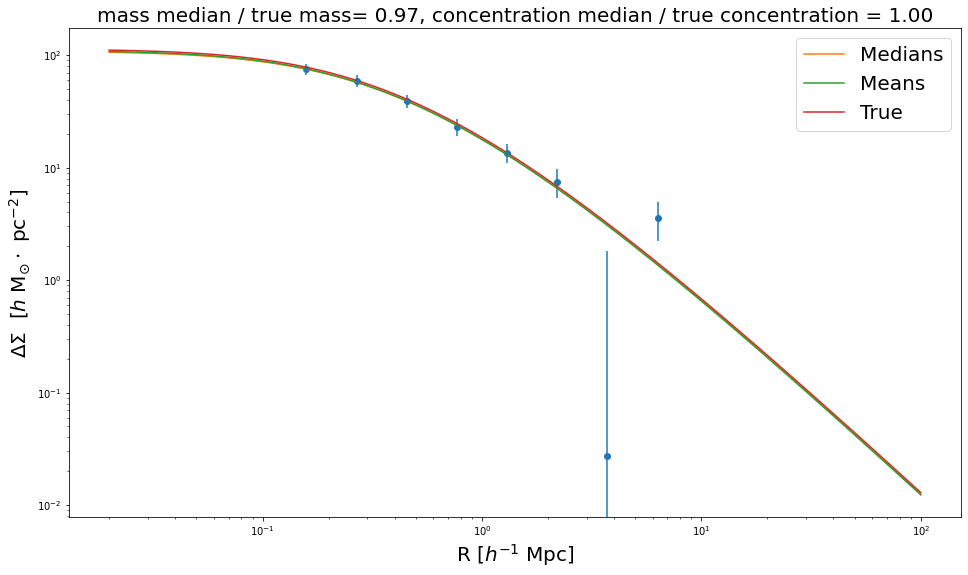

In [22]:
plt.figure(figsize=(16,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')
    
    
Model = xlensing.model.NFW_shear(10**mvir_tru[0],#M200
                                  conc_tru[0],#C200
                                  0.3,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 
plt.plot(radii_model,Model,label='Medians')
Model = xlensing.model.NFW_shear(10**np.average(samples,axis=0)[0],#M200
                                  np.average(samples,axis=0)[1],#C200
                                  0.3,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 



plt.plot(radii_model,Model,label='Means')


Model = xlensing.model.NFW_shear(M200true,#M200
                                  C200true,#C200
                                  0.35,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 

m_ratio = 10**mvir_tru[0]/M200true

c_ratio = conc_tru[0]/C200true
plt.plot(radii_model,Model,label='True')
plt.legend(fontsize=20)
#plt.ylim(1e1,3e3)
#plt.xlim(.8e-1,2e1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\Delta \Sigma$  [$h$ M$_{\odot} \cdot$ pc$^{-2}$] ',fontsize=20)
plt.xlabel('R [$h^{-1}$ Mpc]',fontsize=20)
plt.title(f'mass median / true mass= {m_ratio:.2f}, concentration median / true concentration = {c_ratio:.2f}',fontsize=20)
plt.savefig(f'fit_example_medians_means_{timestamp}.pdf',bbox_inches='tight')

## 100 fittings of the same cluster with different backgrounds

Create galaxies:

In [23]:
M200true = 2e14
C200true = 3.5
Zcluster = 0.3
RAcluster = 0.0 #radians 
DECluster = 0.0 #radians
Ngals = 1e5
stick = []
for i in tqdm.tqdm(range(10)):
  
  E1gals, E2gals, RAgals, DECgals, Zgals = xlensing.testing.gen_gal(Ngals=Ngals,Zcluster=Zcluster)


  epsilon = xlensing.testing.NFW_shear( (M200true,C200true, 0, 0, .3),(RAgals, DECgals, Zgals, E1gals, E2gals) )
  e1gals = np.real(epsilon)
  e2gals = np.imag(epsilon)

  e1err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e1gals])
  e2err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e2gals])
  Wgals = (0.1**2 + e1err**2 +e2err**2)/(0.1**2 + e1err**2 +e2err**2) #w=1
  Mgals = -np.random.exponential(0.03,size=int(Ngals))*0
  
  galaxy_catalog = Table([RAgals,DECgals,Zgals,e1gals,e2gals, Wgals,Mgals],names=['RA','DEC','ZPHOT','E1','E2','WEIGHT','M'])


  sr_RA = np.array(galaxy_catalog['RA'])
  sr_DEC= np.array(galaxy_catalog['DEC'])
  sr_z  = np.array(galaxy_catalog['ZPHOT'])
  sr_E1 = np.array(galaxy_catalog['E1'])
  sr_E2 = np.array(galaxy_catalog['E2'])
  sr_W = np.array(galaxy_catalog['WEIGHT'])
  sr_M = np.array(galaxy_catalog['M'])


  clusters = Table([[RAcluster],[DECluster],[Zcluster]],names=['RA','DEC', 'Z'])
  clusters['INDEX'] = np.array(range(len(clusters)))
  stick.append(clusters)

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


In [24]:
M200true = 2e14
C200true = 3.5
Zcluster = 0.3
RAcluster = 0.0 #radians 
DECluster = 0.0 #radians
Ngals = 1e5
for i in tqdm.tqdm(range(10)):
  
  E1gals, E2gals, RAgals, DECgals, Zgals = xlensing.testing.gen_gal(Ngals=Ngals,Zcluster=Zcluster)


  epsilon = xlensing.testing.NFW_shear( (M200true,C200true, 0, 0, .3),(RAgals, DECgals, Zgals, E1gals, E2gals) )
  e1gals = np.real(epsilon)
  e2gals = np.imag(epsilon)

  e1err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e1gals])
  e2err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e2gals])
  Wgals = (0.1**2 + e1err**2 +e2err**2)/(0.1**2 + e1err**2 +e2err**2) #w=1
  Mgals = -np.random.exponential(0.03,size=int(Ngals))*0
  
  galaxy_catalog = Table([RAgals,DECgals,Zgals,e1gals,e2gals, Wgals,Mgals],names=['RA','DEC','ZPHOT','E1','E2','WEIGHT','M'])


  sr_RA = np.array(galaxy_catalog['RA'])
  sr_DEC= np.array(galaxy_catalog['DEC'])
  sr_z  = np.array(galaxy_catalog['ZPHOT'])
  sr_E1 = np.array(galaxy_catalog['E1'])
  sr_E2 = np.array(galaxy_catalog['E2'])
  sr_W = np.array(galaxy_catalog['WEIGHT'])
  sr_M = np.array(galaxy_catalog['M'])


  clusters = Table([[RAcluster],[DECluster],[Zcluster]],names=['RA','DEC', 'Z'])
  clusters['INDEX'] = np.array(range(len(clusters)))

  pool = Pool(cpu_count()) 


  #We get a partial function with a constant galaxy catalogue to iterate with clusters.
  
  survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, 
                                                                  sr_DEC, 
                                                                  sr_z, 
                                                                  sr_E1, 
                                                                  sr_E2, 
                                                                  sr_W,
                                                                  sr_M),radius=10.)

  #Make a list of clusters to get lensing data
  cl_RA=np.array(clusters['RA'])
  cl_DEC= np.array(clusters['DEC'])
  cl_z= np.array(clusters['Z'])
  cl = np.array([cl_RA,cl_DEC,cl_z]).T
  clz = zip(cl_RA,cl_DEC,cl_z)
  clzlist = [x for x in clz]

  results = pool.map(survey_lensing, clzlist)

  stick = [clusters]
  
  
  radii = np.logspace(-0.8,0.8,8)
  N = len(radii)
  bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                          np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
  bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])


  Nboot=200
  stick_results = []
  for stake in stick:
      t = time.time()
      clusterbkgs = []
      for index in stake['INDEX']:
          Sigma_crit = np.array(results[index]['Critical Density'])
          e_t = np.array(results[index]['Tangential Shear'])
          e_x = np.array(results[index]['Cross Shear'])
          W = np.array(results[index]['Weights'])
          M = np.array(results[index]['Mult. Bias'])
          R = np.array(results[index]['Radial Distance'])
          clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
      print(len(clusterbkgs))
      sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
      stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
      print("Done in " + str(time.time()-t) + " seconds.")
     
  def NFWsimple(theta,Z,radii):
    logM200, C200  = theta
    M200 = np.power(10,logM200)
    result = xlensing.model.NFW_shear(M200, C200, Z, 1.0, 0.001, 1e10,radii)['NFW Signal'] #returns only the main shear signal - all other signals (incl cross signal) available see docstring
    return result

  M200lo, M200hi = 13, 15
  C200lo, C200hi = 0, 10

  priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
  priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
  #priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
  prior = lambda theta : priorM200(theta) + priorC200(theta)# + priorPCC(theta)

  ndim, nwalkers, steps = 2, 256, 256
  samplestick = []
  #for each stack, run MCMC
  burnin=round(steps/4.)
  for stickresult in stick_results:
    mean_z = Zcluster

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        #PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)
  for samples in samplestick:
    mvir_tru,conc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                           zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    #print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    #print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
  
  m_ratio = 10**mvir_tru[0]/M200true
  c_ratio = conc_tru[0]/C200true
  print(m_ratio)
  print(c_ratio)
  mratio_list.append(m_ratio)
  cratio_list.append(c_ratio)
  np.save("mratio_lower_snr.npy",np.array(mratio_list))
  np.save("cratio_lower_snr.npy",np.array(cratio_list))
 

  0%|          | 0/10 [00:00<?, ?it/s]

1
Total galaxies available per bin:
[314, 585, 939, 1574, 2695, 4652, 7833, 13101]

Single cluster:
Separating galaxies per radial bin...
Done in 4.818066358566284 seconds.
Running MCMC...


  0%|          | 0/10 [03:31<?, ?it/s]

Done in 203.28327679634094 seconds.
0.414787478044155
1.826764802503042


NameError: name 'mratio_list' is not defined

## 5 clusters

In [25]:
def mass_lambda_MEP(Lambda):
    Lambda0 = 40
    M0 = 2.21E14
    alpha = 1.18
    
    mass = M0*(Lambda/Lambda0)**alpha
    
    return mass

In [26]:
def c_DuttonMaccio(z, m):
    """Concentration from c(M) relation in Dutton & Maccio (2014).
    Parameters
    ----------
    z : float or array_like
        Redshift(s) of halos.
    m : float or array_like
        Mass(es) of halos (m200 definition), in units of solar masses.
    h : float, optional
        Hubble parameter. Default is from Planck13.
    Returns
    ----------
    ndarray
        Concentration values (c200) for halos.
    References
    ----------
    Calculation from Planck-based results of simulations presented in:
    A.A. Dutton & A.V. Maccio, "Cold dark matter haloes in the Planck era:
    evolution of structural parameters for Einasto and NFW profiles,"
    Monthly Notices of the Royal Astronomical Society, Volume 441, Issue 4,
    p.3359-3374, 2014.
    """


    a = 0.52 + 0.385 * np.exp(-0.617 * (z**1.21))  # EQ 10
    b = -0.101 + 0.026 * z                         # EQ 11

    logc200 = a + b * np.log10(m * 1 / (10.**12))  # EQ 7

    concentration = 10.**logc200

    return concentration

In [27]:
c_DuttonMaccio(.3,4e14)

4.0826185353213065

In [28]:
clusters_z = [0.3, 0.2, 0.35, 0.4, 0.5]
clusters_M = [2, 1, 3, 4, 2 ] #1e14
clusters_C = [c_DuttonMaccio(z, m*1e14)+np.random.normal(0,c_DuttonMaccio(z, m*1e14)/20) 
              for z,m in zip(clusters_z,clusters_M)]

In [29]:
clusters_C

[4.055493170528072,
 4.9025318431099985,
 4.214727728547988,
 4.047283564281916,
 4.156052666033404]

In [30]:
Ngals = 1e5

E1gals, E2gals, RAgals, DECgals, Zgals = xlensing.testing.gen_gal(Ngals=Ngals)

In [31]:
M200lo, M200hi = 13, 15
C200lo, C200hi = 0, 10
priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)

In [32]:
model = lambda theta: NFWsimple(theta,mean_z,radii)
likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
posterior = lambda theta : likelihood(theta) +prior(theta)


The plan!

Find a concentration - offset scaling relation like mass/lambda

1. get a pivot/offset slope

2. use a mass/lambda slope (redMaPPer)

3. using  2, gets masses

4. using 1 & 3 + m-C relation gets C - Diemer, Joyce

5. NFW likelihood for each

6. sum all likelihoods